Het voorspellen van de bondprijs alleen op basis van historische waarde van de bond is waarschijnlijk nooit erg succesvol. Voor een betere voorspelling zullen we 'leading indicatoren' moeten hebben. Indicatoren die iets zeggen waar de markt naar toe gaat.

Voor dit onderzoek richt ik mij op deze indicatoren:
- Remaining Duration
- Theoretical Bond Prices
- Inflation curve
- Referentie bond (Germany 10 years)
- Term Spread
- Bid Offer Spread

In [37]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons
    %cd BondTrading

In [53]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")

import math
from src.data import make_dataset
from src.models import base_model,evaluate
from src.visualization import visualize
from pathlib import Path
import pandas as pd
from src.models import window

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
if IS_COLAB:
    df_bonds = make_dataset.get_bond_data(path = Path("data/raw/price.csv"))
    df_bonds = make_dataset.impute_bonds(df_bonds)
    df_price = make_dataset.get_price(path = Path("data/raw/price.csv"))
    df_price = make_dataset.impute_price(df_price)
    df_bp = make_dataset.join_price(df_bonds,df_price )
    df_bp = make_dataset.build_features.add_duration(df_bp)
else:
    df_bp = make_dataset.read_pkl('bp', path = Path("data/processed/")) 
   
isin = "NL0011220108" # 10 Years NL Bond, maturity 2025 0.25% coupon
df_isin = df_bp[df_bp['reference_identifier'] == isin]


2022-01-24 16:09:05.890 | INFO     | src.data.make_dataset:read_pkl:398 - Load preprocessed bp data


In [161]:
df_isin

,reference_identifier,ccy,rate_dt,mid,lastday,country,bond_ext_name,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration,remain_duration
29956,NL0011220108,EUR,2015-03-24,98.607,2015-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,3766
30102,NL0011220108,EUR,2015-03-25,98.539,2015-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,3765
30155,NL0011220108,EUR,2015-03-26,98.612,2015-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,3764
30195,NL0011220108,EUR,2015-03-27,98.683,2015-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,3763
30354,NL0011220108,EUR,2015-03-30,98.864,2015-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,3760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223150,NL0011220108,EUR,2022-01-03,102.530,2022-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,1289
223346,NL0011220108,EUR,2022-01-04,102.551,2022-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,1288
223542,NL0011220108,EUR,2022-01-05,102.481,2022-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,1287
223738,NL0011220108,EUR,2022-01-06,102.411,2022-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,NL0011220108,STAAT DER NEDERLANDEN,ANNUAL,0.25,6705.159,DBFXXN,AAA,3764,1286


In [162]:
df_yield = make_dataset.read_pkl('yield', path = Path("data/processed/")) 
df_y = df_yield[['country', 'rate_dt','time', 'mid']].rename(columns={ 'mid': 'ytm'})
df = df_isin.merge(df_y, on = ['country','rate_dt'], how = 'inner')
df = df[ df['time'].dt.days > df.remain_duration ]
df = df.sort_values(by = ['reference_identifier','rate_dt','time'])
df = df.groupby(['reference_identifier','rate_dt']).first()
df = df.reset_index()
df_isin = df


2022-01-24 16:09:11.164 | INFO     | src.data.make_dataset:read_pkl:398 - Load preprocessed yield data


     reference_identifier    rate_dt  ccy      mid     lastday      country  \
0            NL0011220108 2016-06-01  EUR  100.251  2016-12-31  Netherlands   
1            NL0011220108 2016-06-02  EUR  100.319  2016-12-31  Netherlands   
2            NL0011220108 2016-06-03  EUR  100.702  2016-12-31  Netherlands   
3            NL0011220108 2016-06-06  EUR  100.632  2016-12-31  Netherlands   
4            NL0011220108 2016-06-07  EUR  100.751  2016-12-31  Netherlands   
...                   ...        ...  ...      ...         ...          ...   
1425         NL0011220108 2022-01-03  EUR  102.530  2022-12-31  Netherlands   
1426         NL0011220108 2022-01-04  EUR  102.551  2022-12-31  Netherlands   
1427         NL0011220108 2022-01-05  EUR  102.481  2022-12-31  Netherlands   
1428         NL0011220108 2022-01-06  EUR  102.411  2022-12-31  Netherlands   
1429         NL0011220108 2022-01-07  EUR  102.351  2022-12-31  Netherlands   

                bond_ext_name   issue_dt first_coup

In [ ]:
df_isin['coun']

In [186]:
df_isin['first_coupon_date']

0      2015-07-15
1      2015-07-15
2      2015-07-15
3      2015-07-15
4      2015-07-15
          ...    
1425   2015-07-15
1426   2015-07-15
1427   2015-07-15
1428   2015-07-15
1429   2015-07-15
Name: first_coupon_date, Length: 1430, dtype: datetime64[ns]

In [180]:
def calculate_ytm( 
    row
) -> float:
        
    periods = (row['remain_duration'] / 365) 
    ytm = row['ytm'] / 100
    coupon = row['coupon'] / 100
    if (row['coupon_frq'] == 'ANNUAL'):
        frequency = 1
    else:
        frequency = 2
    par_value = 100    
    i = coupon / frequency * par_value
    p = (1 - ( 1 + ytm / frequency ) ** (-periods))/(ytm / frequency)
    pi = p * i
    k = par_value / ( ( 1 + ytm/frequency ) ** periods)
    price = k + pi
    return (price)

df_isin['estimated_bondprice'] = df_isin.apply( calculate_ytm, axis = 1 )


<AxesSubplot:xlabel='rate_dt'>

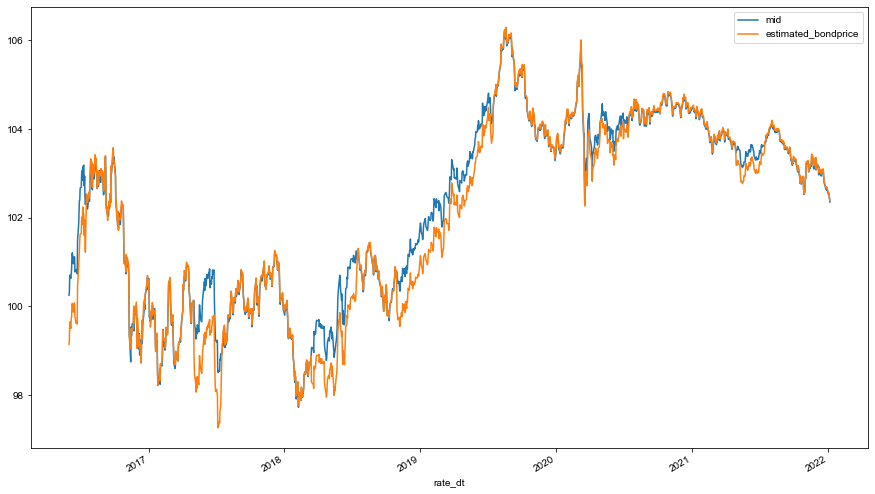

In [182]:
df_isin.plot(x = 'rate_dt',y = ['mid','estimated_bondprice'], figsize = (15,9))


<AxesSubplot:xlabel='rate_dt'>

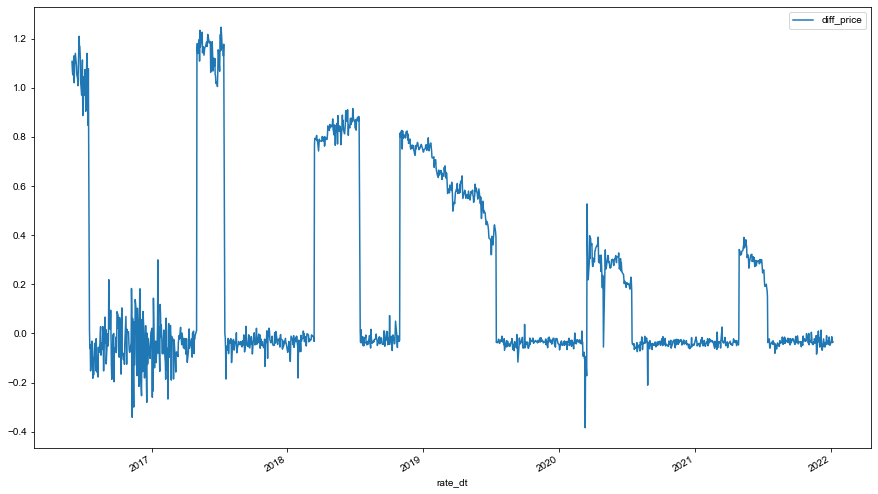

In [184]:
df_isin['diff_price'] = df['mid'] - df['estimated_bondprice']
df_isin.plot(x = 'rate_dt',y = 'diff_price', figsize = (15,9))

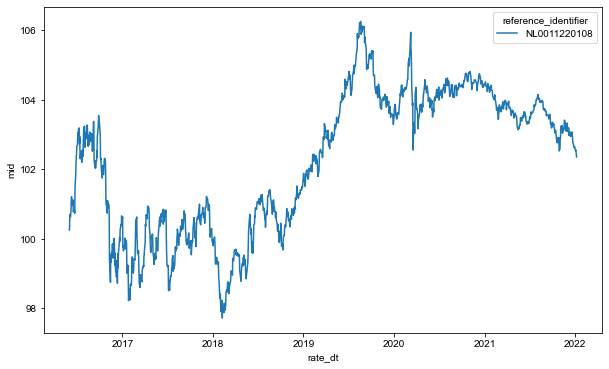

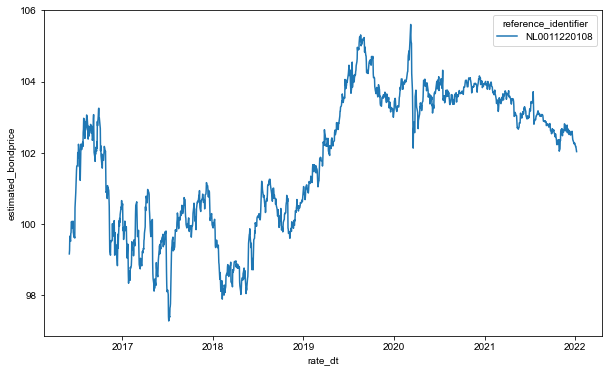

In [168]:
ax = visualize.lineplot(df_isin,x = 'rate_dt', y = 'mid',hue = 'reference_identifier', figurepath = Path("reports/figures"), name = 'timeseries traintestsplit')
ax = visualize.lineplot(df_isin,x = 'rate_dt', y = 'estimated_bondprice',hue = 'reference_identifier', figurepath = Path("reports/figures"), name = 'timeseries traintestsplit')



In [31]:
(1 + ytm) / coupon_rate

2.08

In [29]:
pow(2.08,-3.5)

0.07705100853097978

In [40]:
df_isin = df_isin.set_index('rate_dt')
df_isin = df_isin.sort_index()
df_isin = df_isin[['mid','remain_duration']]

In [6]:
df_isin



,mid,remain_duration
rate_dt,,
2015-03-24,98.607,3766
2015-03-25,98.539,3765
2015-03-26,98.612,3764
2015-03-27,98.683,3763
2015-03-30,98.864,3760
...,...,...
2022-01-03,102.530,1289
2022-01-04,102.551,1288
2022-01-05,102.481,1287


In [41]:
split = math.floor(len(df_isin) * .70)

# Train test split
train = df_isin[:split]
test = df_isin[split:]
tmin = train.min()
tmax = train.max()
train=(train-tmin)/(tmax-tmin)
test =(test- tmin)/(tmax-tmin)

<AxesSubplot:xlabel='rate_dt'>

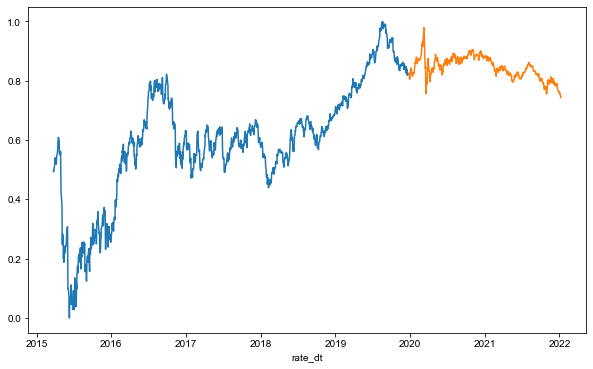

In [8]:
visualize.timeplot(train['mid'], test['mid'], figurepath = Path("reports/figures"), name = 'timeseries traintestsplit')

In [42]:
# Create a windowed dataset from the data
window_size = 32 
batch_size = 32
shuffle_buffer = 2
horizon = 10
train_set = window.windowed_dataset_from_df(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset_from_df(test, window_size, batch_size, shuffle_buffer, horizon=horizon)

2022-01-24 11:47:48.543 | INFO     | src.models.window:windowed_dataset_from_df:12 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10
2022-01-24 11:47:48.575 | INFO     | src.models.window:windowed_dataset_from_df:12 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10


We have 1 features!
We have 1 features!


In [44]:
y, yhat = base_model.naivepredict(train.iloc[:, 0].values)
norm = evaluate.mae(y, yhat)
evaluate.mae(y, yhat), evaluate.mse(y, yhat), evaluate.mase(y, yhat)

(0.012229328185583187, 0.00031282996870604906, 0.9994767468190888)

In [51]:
# Mean Absolute Error - for horizon
norm = base_model.calc_mae_for_horizon(train_set, horizon)
print(norm)
smae = evaluate.ScaledMAE(scale=norm)

0.027770603838435614


In [52]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([32, 32, 2]), TensorShape([32, 10]))

In [ ]:
result = {}
models = {}

In [56]:
model = Sequential([                  
        tfl.SimpleRNN(1),
        tfl.Dense(horizon)
    ])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr = 1e-2
model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop], verbose=1)

Epoch 1/200
37/37 [==============================] - 8s 128ms/step - loss: 0.2136 - mae: 0.4342 - smae: 15.6359 - val_loss: 0.2367 - val_mae: 0.4842 - val_smae: 17.4352
Epoch 2/200
37/37 [==============================] - 4s 109ms/step - loss: 0.0510 - mae: 0.1942 - smae: 6.9947 - val_loss: 0.0913 - val_mae: 0.2986 - val_smae: 10.7518
Epoch 3/200
37/37 [==============================] - 4s 111ms/step - loss: 0.0358 - mae: 0.1418 - smae: 5.1070 - val_loss: 0.0536 - val_mae: 0.2211 - val_smae: 7.9611
Epoch 4/200
37/37 [==============================] - 4s 114ms/step - loss: 0.0383 - mae: 0.1439 - smae: 5.1825 - val_loss: 0.0391 - val_mae: 0.1803 - val_smae: 6.4915
Epoch 5/200
37/37 [==============================] - 4s 114ms/step - loss: 0.0364 - mae: 0.1388 - smae: 4.9966 - val_loss: 0.0251 - val_mae: 0.1358 - val_smae: 4.8901
Epoch 6/200
37/37 [==============================] - 4s 112ms/step - loss: 0.0264 - mae: 0.1104 - smae: 3.9742 - val_loss: 0.0090 - val_mae: 0.0734 - val_smae: 2.

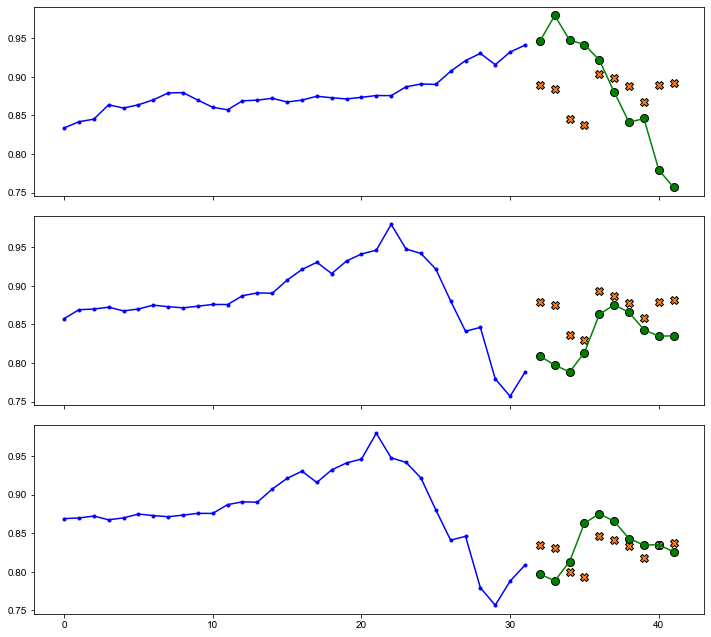

In [74]:
fig = visualize.plot_example(
    valid_set, 
    window_size = window_size, 
    horizon = horizon, 
    examples = 3, 
    model = model,
    figurepath = Path("reports/figures"), 
    name = 'example base model')